In [2]:
import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import lightgbm as lgb
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from xgboost import plot_importance

import time
import datetime
import re
from itertools import product
from math import isnan
import scipy.stats as stats

import gc
import pickle

import os

In [3]:
# Load input files
sales_train = pd.read_csv("D:/Datasets/competitive-data-science-predict-future-sales/sales_train.csv", parse_dates=['date'], infer_datetime_format=False, dayfirst=True)
test = pd.read_csv("D:/Datasets/competitive-data-science-predict-future-sales/test.csv")
item_categories = pd.read_csv("D:/Datasets/competitive-data-science-predict-future-sales/item_categories.csv")
items = pd.read_csv("D:/Datasets/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("D:/Datasets/competitive-data-science-predict-future-sales/shops.csv")

# Take a brief look on the content
print("Sales_train")
display(sales_train.head(10))
print("Test")
display(test.head(10))
print("Item_categories")
display(item_categories.head(10))
print("Items")
display(items.head(10))
print("Shops")
display(shops.head(1))

# Auxiliar function to reduce data storage
def downcast_dtypes(df):
    # Columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float16)
    df[int_cols]   = df[int_cols].astype(np.int16)
    return df

# Prepare the test set to merge it with sales_train
test['date_block_num'] = 34
test['date'] = datetime.datetime(2015, 11, 1, 0, 0, 0)

# Join train and test sets. Fill date_block_num = 34 for test rows 
all_data = pd.concat([sales_train, test], axis = 0, sort=False)
all_data['date_block_num'].fillna(34, inplace=True)

# Create flag (in_test) for month=34
all_data['in_test'] = 0
all_data.loc[all_data.date_block_num == 34, 'in_test'] = 1

# Create a flag (is_new_item) for elements in test not in sales_train
new_items = (set(test['item_id'].unique()) - set(sales_train['item_id'].unique()))
all_data.loc[all_data['item_id'].isin(new_items), 'is_new_item'] = 1

# Fill missings with 0
all_data.fillna(0, inplace=True)
all_data = downcast_dtypes(all_data)
all_data = all_data.reset_index()
display(all_data.head(10))

print("Train set size: ", len(sales_train))
print("Test set size: ", len(test))
print("Item categories set size: ", len(item_categories))
print("Items set size: ", len(items))
print("Shops set size: ", len(shops))
print("All data size: ", len(all_data))
print("Duplicates in train dataset: ", len(sales_train[sales_train.duplicated()]))

Sales_train


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
6,2013-01-02,0,25,2565,549.00,1.0
7,2013-01-04,0,25,2572,239.00,1.0
8,2013-01-11,0,25,2572,299.00,1.0
9,2013-01-03,0,25,2573,299.00,3.0


Test


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
5,5,5,5039
6,6,5,5041
7,7,5,5046
8,8,5,5319
9,9,5,5003


Item_categories


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


Items


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
5,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40
6,***УДАР ПО ВОРОТАМ (UNI) D,6,40
7,***УДАР ПО ВОРОТАМ-2 (UNI) D,7,40
8,***ЧАЙ С МУССОЛИНИ D,8,40
9,***ШУГАРЛЭНДСКИЙ ЭКСПРЕСС (UNI) D,9,40


Shops


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


,index,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,in_test,is_new_item
0,0,2013-01-02,0,59,22154,999.0,1.0,0.0,0,0.0
1,1,2013-01-03,0,25,2552,899.0,1.0,0.0,0,0.0
2,2,2013-01-05,0,25,2552,899.0,-1.0,0.0,0,0.0
3,3,2013-01-06,0,25,2554,1709.0,1.0,0.0,0,0.0
4,4,2013-01-15,0,25,2555,1099.0,1.0,0.0,0,0.0
5,5,2013-01-10,0,25,2564,349.0,1.0,0.0,0,0.0
6,6,2013-01-02,0,25,2565,549.0,1.0,0.0,0,0.0
7,7,2013-01-04,0,25,2572,239.0,1.0,0.0,0,0.0
8,8,2013-01-11,0,25,2572,299.0,1.0,0.0,0,0.0
9,9,2013-01-03,0,25,2573,299.0,3.0,0.0,0,0.0


Train set size:  2935849
Test set size:  214200
Item categories set size:  84
Items set size:  22170
Shops set size:  60
All data size:  3150049
Duplicates in train dataset:  6


,index,date_block_num,shop_id,item_id,item_price,item_cnt_day,ID,in_test,is_new_item
count,3.150049e+06,3.150049e+06,3.150049e+06,3.150049e+06,3150049.0,3150049.0,3150049.0,3.150049e+06,3.150049e+06
mean,1.375389e+06,1.589114e+01,3.290933e+01,1.025313e+04,NaN,NaN,NaN,6.799894e-02,4.840851e-03
std,8.871567e+05,1.032864e+01,1.632479e+01,6.322838e+03,NaN,NaN,NaN,2.517441e-01,6.939697e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.0,-22.0,0.0,0.000000e+00,0.000000e+00
25%,5.733120e+05,7.000000e+00,2.200000e+01,4.510000e+03,199.0,1.0,0.0,0.000000e+00,0.000000e+00
50%,1.360824e+06,1.500000e+01,3.100000e+01,9.461000e+03,399.0,1.0,0.0,0.000000e+00,0.000000e+00
75%,2.148336e+06,2.400000e+01,4.700000e+01,1.572700e+04,899.0,1.0,0.0,0.000000e+00,0.000000e+00
max,2.935848e+06,3.400000e+01,5.900000e+01,2.216900e+04,inf,2168.0,inf,1.000000e+00,1.000000e+00


Item_price outlier: 
index                         1163158
date              2013-12-13 00:00:00
date_block_num                     11
shop_id                            12
item_id                          6066
item_price                        inf
item_cnt_day                        1
ID                                  0
in_test                             0
is_new_item                         0
Name: 1163158, dtype: object

Item_cnt_day maximum: 
index                         2909818
date              2015-10-28 00:00:00
date_block_num                     33
shop_id                            12
item_id                         11373
item_price                   0.908691
item_cnt_day                     2168
ID                                  0
in_test                             0
is_new_item                         0
Name: 2909818, dtype: object
['!Якутск Орджоникидзе, 56 фран' '!Якутск ТЦ "Центральный" фран'
 'Адыгея ТЦ "Мега"' 'Балашиха ТРК "Октябрь-Киномир"'
 'Волжский ТЦ "Волг

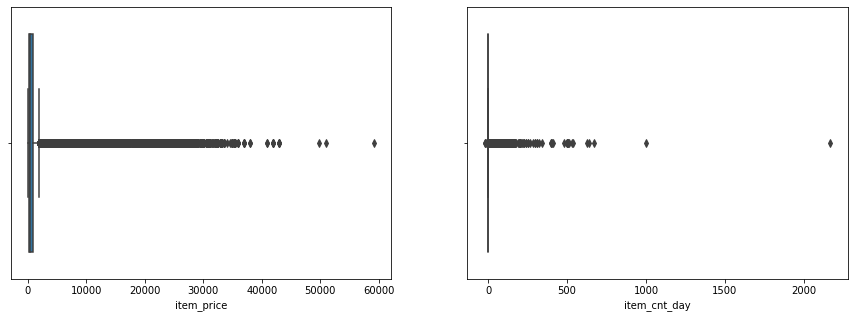

In [4]:
# Describe merged data to look for unusual values
display(all_data.describe())
print("Item_price outlier: ")
print(all_data.loc[all_data['item_price'].idxmax()])
print("\nItem_cnt_day maximum: ")
print(all_data.loc[all_data['item_cnt_day'].idxmax()])

f1, axes = plt.subplots(1, 2, figsize=(15,5))
f1.subplots_adjust(hspace=0.4, wspace=0.2)
sns.boxplot(x=all_data['item_price'], ax=axes[0])
sns.boxplot(x=all_data['item_cnt_day'], ax=axes[1])

print(shops['shop_name'].unique())

In [5]:
# Drop outliers and negative counts (see graphs below)
all_data = all_data.drop(all_data[all_data['item_price']>100000].index)
all_data = all_data.drop(all_data[all_data['item_cnt_day']>1100].index)
sales_train = sales_train.drop(sales_train[sales_train['item_price']>100000].index)
sales_train = sales_train.drop(sales_train[sales_train['item_cnt_day']>1100].index)

# There are shops with same address and almost same name in russian. 
# Unify duplicated shops (see https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
all_data.loc[all_data['shop_id'] == 11,'shop_id'] = 10
all_data.loc[all_data['shop_id'] == 57,'shop_id'] = 0
all_data.loc[all_data['shop_id'] == 58,'shop_id'] = 1
sales_train.loc[sales_train['shop_id'] == 11,'shop_id'] = 10
sales_train.loc[sales_train['shop_id'] == 57,'shop_id'] = 0
sales_train.loc[sales_train['shop_id'] == 58,'shop_id'] = 1
test.loc[test['shop_id'] == 11,'shop_id'] = 10
test.loc[test['shop_id'] == 57,'shop_id'] = 0
test.loc[test['shop_id'] == 58,'shop_id'] = 1

# Instead of deleting negative price items, replace them with the median value for the impacted group:
all_data.loc[all_data['item_price'] < 0, 'item_price'] = all_data[(all_data['shop_id'] == 32) & 
                                                                  (all_data['item_id'] == 2973) & 
                                                                  (all_data['date_block_num'] == 4) & 
                                                                  (all_data['item_price'] > 0)].item_price.median()

print("Raw data length: ",len(sales_train), ", post-outliers length: ", len(all_data))

Raw data length:  2935847 , post-outliers length:  3150047


In [6]:
ts = time.time()

# Enrich data with additional features and aggregates for data exploration purposes
def enrich_data(all_data, items, shops, item_categories):
    
    # Aggregate at month level. Calculate item_cnt_month and item_price (median)
    count_data = all_data.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
    price_data = all_data.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_price'].median().rename('item_price_median').reset_index()
    all_data = pd.merge(count_data, price_data, on=['shop_id', 'item_id', 'in_test', 'date_block_num', 'is_new_item'], how='left')

    # Extract day, month, year
    #all_data['day'] = all_data['date'].dt.day
    #all_data['month'] = all_data['date'].dt.month
    #all_data['year'] = all_data['date'].dt.year

    # Add item, shop and item_category details 
    all_data = all_data.join(items, on='item_id', rsuffix='_item')
    all_data = all_data.join(shops, on='shop_id', rsuffix='_shop')
    all_data = all_data.join(item_categories, on='item_category_id', rsuffix='_item_category')
    all_data = all_data.drop(columns=['item_id_item', 'shop_id_shop', 'item_category_id_item_category', 'item_name'])
    
    # Extract main category and subcategory from category name
    categories_split = all_data['item_category_name'].str.split('-')
    all_data['main_category'] = categories_split.map(lambda row: row[0].strip())
    all_data['secondary_category'] = categories_split.map(lambda row: row[1].strip() if (len(row)>1) else 'N/A')
    
     # Extract cities information from shop_name. Replace !Якутск by Якутск since it's the same city
    all_data['city'] = all_data['shop_name'].str.split(' ').map(lambda row: row[0])
    all_data.loc[all_data.city == '!Якутск', 'city'] = 'Якутск'

    # Encode cities and categories
    encoder = sklearn.preprocessing.LabelEncoder()
    all_data['city_label'] = encoder.fit_transform(all_data['city'])
    all_data['main_category_label'] = encoder.fit_transform(all_data['main_category'])
    all_data['secondary_category_label'] = encoder.fit_transform(all_data['secondary_category'])
    all_data = all_data.drop(['city', 'shop_name', 'item_category_name', 'main_category', 'secondary_category'], axis = 1)

    # Create price categories (0-5, 5-10, 10,20, 20,30, 30-50, 50-100, >100)
    def price_category(row):
        if row.item_price_median<5.:
            val = 1
        elif row.item_price_median<10.:
            val = 2
        elif row.item_price_median<100.:
            val = 3
        elif row.item_price_median<200.:
            val = 4
        elif row.item_price_median<300.:
            val = 5
        elif row.item_price_median<500.:
            val = 6
        elif row.item_price_median<1000.:
            val = 7
        elif row.item_price_median>1000.:
            val = 8
        else:
            val = 0
        return val
    
    all_data['price_cat'] = all_data.apply(price_category, axis=1)
    
    # Downgrade numeric data types
    all_data = downcast_dtypes(all_data)
    
    # Performance test dropping month_cnt
    #all_data.drop('item_cnt_month', axis=1, inplace=True)
    
    return all_data

all_data2 = enrich_data(all_data, items, shops, item_categories)
items_prices = all_data2[['item_id', 'shop_id', 'date_block_num', 'item_price_median', 'price_cat']]

time.time() - ts

all_data2.head()

,shop_id,item_id,date_block_num,in_test,is_new_item,item_cnt_month,item_price_median,item_category_id,city_label,main_category_label,secondary_category_label,price_cat
0,0,30,1,0,0.0,31.0,265.0,40,29,11,4,5
1,0,30,2,0,0.0,24.0,399.0,40,29,11,4,6
2,0,30,3,0,0.0,3.0,399.0,40,29,11,4,6
3,0,30,4,0,0.0,1.0,399.0,40,29,11,4,6
4,0,30,6,0,0.0,1.0,399.0,40,29,11,4,6


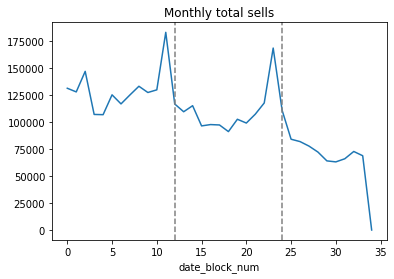

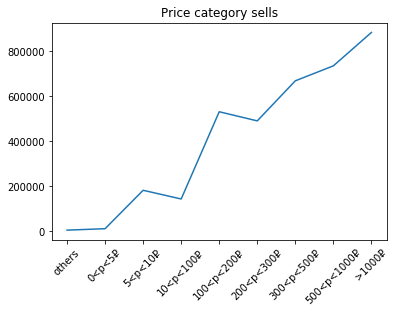

In [7]:
# Analyze monthly sells for all shops
all_data2['item_cnt_month'] = all_data2['item_cnt_month'].astype(np.float64)
count_monthly_sales = all_data2.groupby('date_block_num').item_cnt_month.sum(axis=0)

f = plt.figure()
ax = f.add_subplot(111)
plt.plot(count_monthly_sales)
plt.axvline(x=12,color='grey',linestyle='--')  # Vertical grey line for December month
plt.axvline(x=24,color='grey',linestyle='--')
plt.xlabel("date_block_num")
plt.title('Monthly total sells')
plt.show()

# Analyze monthly sells for each price category
count_price_cat_sales = all_data2.groupby('price_cat').item_cnt_month.sum(axis=0)

f = plt.figure()
ax = f.add_subplot(111)
plt.plot(count_price_cat_sales)
plt.xticks([0,1,2,3,4,5,6,7,8],['others', '0<p<5₽','5<p<10₽','10<p<100₽','100<p<200₽','200<p<300₽','300<p<500₽','500<p<1000₽','>1000₽'], rotation='45')
plt.title('Price category sells')
plt.show()

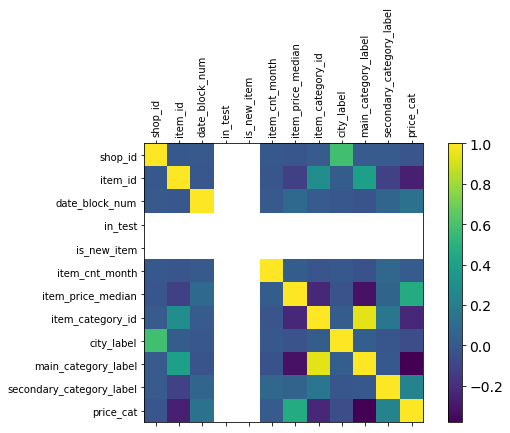

In [8]:
# Correlation matrix for monthly sales
all_data2 = all_data2[all_data2['date_block_num']<34]
#all_data2 = all_data2.drop(columns=['in_test', 'is_new_item'], inplace=True)

# Correlation matrix
f = plt.figure(figsize=(9, 5))
plt.matshow(all_data2.corr(), fignum=f.number)
plt.xticks(range(all_data2.shape[1]),all_data2.columns, fontsize=10, rotation=90)
plt.yticks(range(all_data2.shape[1]), all_data2.columns, fontsize=10)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [9]:
# Missings count. There are no missings (remind that we filled all missings on the beginning of this kernel with  0s)
missings_count = {col:all_data[col].isnull().sum() for col in all_data.columns}
missings = pd.DataFrame.from_dict(missings_count, orient='index')
print(missings.nlargest(30, 0))

                0
index           0
date            0
date_block_num  0
shop_id         0
item_id         0
item_price      0
item_cnt_day    0
ID              0
in_test         0
is_new_item     0


In [10]:
ts = time.time()

# Extend all_data for all item/shop pairs. 
def add_all_pairs(sales_train, test, items, shops, item_categories, items_prices):
    
    tmp = []
    for month in range(34):
        sales = sales_train[sales_train.date_block_num==month]
        tmp.append(np.array(list(product([month], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))

    tmp = pd.DataFrame(np.vstack(tmp), columns=['date_block_num','shop_id','item_id'])
    tmp['date_block_num'] = tmp['date_block_num'].astype(np.int8)
    tmp['shop_id'] = tmp['shop_id'].astype(np.int8)
    tmp['item_id'] = tmp['item_id'].astype(np.int16)
    tmp.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
    
    sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']
    group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
    group.columns = ['item_cnt_month']
    group.reset_index(inplace=True)
    tmp = pd.merge(tmp, group, on=['date_block_num','shop_id','item_id'], how='left')
    tmp['item_cnt_month'] = (tmp['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))
    tmp = pd.concat([tmp, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
    
    #price_data = tmp.groupby(['shop_id', 'item_id', 'date_block_num', 'in_test', 'is_new_item'])['item_price'].median().rename('item_price_median').reset_index()
    #tmp = tmp.join(price_data, on=[[]])
    
    # Add item, shop and item_category details 
    tmp = tmp.join(items, on='item_id', rsuffix='_item')
    tmp = tmp.join(shops, on='shop_id', rsuffix='_shop')
    tmp = tmp.join(item_categories, on='item_category_id', rsuffix='_item_category')
    tmp = pd.merge(tmp, items_prices, on=['date_block_num','shop_id','item_id'], how='left')
    tmp = tmp.drop(columns=['item_id_item', 'shop_id_shop', 'item_category_id_item_category', 'item_name'])
    
    # Extract month, year & nºdays in each month
    tmp['month'] = tmp['date_block_num']%12
    tmp['days'] = tmp['month'].map(pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]))
    
    # Extract main category and subcategory from category name
    categories_split = tmp['item_category_name'].str.split('-')
    tmp['main_category'] = categories_split.map(lambda row: row[0].strip())
    tmp['secondary_category'] = categories_split.map(lambda row: row[1].strip() if (len(row)>1) else 'N/A')
    
    # Extract cities information from shop_name. Replace !Якутск by Якутск since it's the same city.
    tmp['city'] = tmp['shop_name'].str.split(' ').map(lambda row: row[0])
    tmp.loc[tmp.city == '!Якутск', 'city'] = 'Якутск'
    tmp['shop_type'] = tmp['shop_name'].apply(lambda x: 'мтрц' if 'мтрц' in x 
                                              else 'трц' if 'трц' in x 
                                              else 'трк' if 'трк' in x 
                                              else 'тц' if 'тц' in x 
                                              else 'тк' if 'тк' in x 
                                              else 'NO_DATA')

    # Encode cities and categories
    encoder = sklearn.preprocessing.LabelEncoder()
    tmp['city_label'] = encoder.fit_transform(tmp['city'])
    tmp['shop_type_label'] = encoder.fit_transform(tmp['shop_type'])
    tmp['main_category_label'] = encoder.fit_transform(tmp['main_category'])
    tmp['secondary_category_label'] = encoder.fit_transform(tmp['secondary_category'])
    tmp = tmp.drop(['ID', 'city', 'date', 'shop_name', 'item_category_name', 'main_category', 'secondary_category'], axis = 1)
    
    # Downgrade numeric data types
    tmp = downcast_dtypes(tmp)

    tmp.fillna(0, inplace=True)
    return tmp
    
all_pairs = add_all_pairs(sales_train, test, items, shops, item_categories, items_prices)

time.time() - ts

126.59382057189941

In [11]:
ts = time.time()

# First downgrade some columns (still more) to fasten the mean encoding
all_pairs['date_block_num'] = all_pairs['date_block_num'].astype(np.int8)
all_pairs['city_label'] = all_pairs['city_label'].astype(np.int8)
all_pairs['item_cnt_month'] = all_pairs['item_cnt_month'].astype(np.int8)
all_pairs['item_category_id'] = all_pairs['item_category_id'].astype(np.int8)
all_pairs['main_category_label'] = all_pairs['main_category_label'].astype(np.int8)
all_pairs['secondary_category_label'] = all_pairs['secondary_category_label'].astype(np.int8)

# Function to calculate lag over different columns. Lag gives information about a variable from different past times
def calculate_lag(df, lag, column):
    ancilla = df[['date_block_num','shop_id','item_id',column]]
    for l in lag:
        shift_ancilla = ancilla.copy()
        shift_ancilla.columns = ['date_block_num','shop_id','item_id', column+'_lag_'+str(l)]
        shift_ancilla['date_block_num'] += l
        df = pd.merge(df, shift_ancilla, on=['date_block_num','shop_id','item_id'], how='left')
    return df

# Function to specify lag columns,compute item_cnt aggregate (mean) and call calculate_lag
def prepare_lag_columns(df, lag, column_list, name):
    ancilla = df.groupby(column_list).agg({'item_cnt_month':['mean']})
    ancilla.columns = [name]
    ancilla.reset_index(inplace=True)
    df = pd.merge(df, ancilla, on=column_list, how='left')
    df[name] = df[name].astype(np.float16)
    df = calculate_lag(df, lag, name)
    df.drop([name], axis=1, inplace=True)
    return df

# Auxiliar function to compute item_price groups (for trends). Lags will be calculated post-preparation
def prepare_lag_columns_price(df, column_list, name):
    ancilla = sales_train.groupby(column_list).agg({'item_price':['mean']})
    ancilla.columns = [name]
    ancilla.reset_index(inplace=True)
    df = pd.merge(df, ancilla, on=column_list, how='left')
    df[name] = df[name].astype(np.float16)
    return df

# Let's compute all lags for sells. Arguments of the function are :(df, lag_list, column_list, name of the column)
all_pairs = calculate_lag(all_pairs, [1,2,3,4,5,6,12], 'item_cnt_month')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'item_id'], 'total_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1,2,3,4,5,6,12], ['date_block_num'], 'item_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1,2,3,4,5,6,12], ['date_block_num', 'shop_id'], 'shop_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','city_label'], 'city_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','item_id','city_label'], 'item_city_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'item_category_id'], 'category_id_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'main_category_label'], 'main_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num', 'secondary_category_label'], 'secondary_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','item_category_id'], 'shop_category_id_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','main_category_label'], 'shop_main_category_avg_month_cnt')
all_pairs = prepare_lag_columns(all_pairs, [1], ['date_block_num','shop_id','secondary_category_label'], 'shop_secondary_category_avg_month_cnt')


# For item_price the procedure is more tricky. Compute both item price and monthly price in order to compute the trend.
all_pairs = prepare_lag_columns_price(all_pairs, ['item_id'], 'item_avg_price')
all_pairs = prepare_lag_columns_price(all_pairs, ['date_block_num','item_id'], 'item_avg_price_month')
all_pairs = calculate_lag(all_pairs, [1,2,3,4,5,6], 'item_avg_price_month')

for lag in [1,2,3,4,5,6]:
    all_pairs['trend_price_lag_'+str(lag)] = (all_pairs['item_avg_price_month_lag_'+str(lag)] - all_pairs['item_avg_price']) / all_pairs['item_avg_price']

def clean_trend_price_lag(row):
    for l in [1,2,3,4,5,6]:
        if row['trend_price_lag_'+str(l)]:
            return row['trend_price_lag_'+str(l)]
    return 0

# For some reason my kernel expodes when using df.apply() for all rows, so I had to segment it
dummy_1, dummy_2, dummy_3, dummy_4 = [], [], [], []      
dummy_1 = pd.DataFrame(dummy_1)
dummy_2 = pd.DataFrame(dummy_2)
dummy_3 = pd.DataFrame(dummy_3)
dummy_4 = pd.DataFrame(dummy_4)
dummy_1 = all_pairs[:3000000].apply(clean_trend_price_lag, axis=1)
dummy_2 = all_pairs[3000000:6000000].apply(clean_trend_price_lag, axis=1)
dummy_3 = all_pairs[6000000:9000000].apply(clean_trend_price_lag, axis=1)
dummy_4 = all_pairs[9000000:].apply(clean_trend_price_lag, axis=1)
all_pairs['trend_price_lag'] = pd.concat([dummy_1, dummy_2, dummy_3, dummy_4])
all_pairs['trend_price_lag'] = all_pairs['trend_price_lag'].astype(np.float16)
all_pairs['trend_price_lag'].fillna(0, inplace=True)

#all_pairs.drop(['item_avg_price','item_avg_price_month'], axis=1, inplace=True)
for i in [1,2,3,4,5,6]:
    all_pairs.drop(['item_avg_price_month_lag_'+str(i), 'trend_price_lag_'+str(i)], axis=1, inplace=True)

all_pairs.drop('shop_type', axis=1, inplace=True)
time.time() - ts

617.798877954483

In [12]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

all_pairs = pd.merge(all_pairs, group, on=['date_block_num','shop_id'], how='left')
all_pairs['date_shop_revenue'] = all_pairs['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

all_pairs = pd.merge(all_pairs, group, on=['shop_id'], how='left')
all_pairs['shop_avg_revenue'] = all_pairs['shop_avg_revenue'].astype(np.float32)

all_pairs['delta_revenue'] = (all_pairs['date_shop_revenue'] - all_pairs['shop_avg_revenue']) / all_pairs['shop_avg_revenue']
all_pairs['delta_revenue'] = all_pairs['delta_revenue'].astype(np.float16)

all_pairs = calculate_lag(all_pairs, [1], 'delta_revenue')

all_pairs.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

# First sale extraction
all_pairs['item_shop_first_sale'] = all_pairs['date_block_num'] - all_pairs.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
all_pairs['item_first_sale'] = all_pairs['date_block_num'] - all_pairs.groupby('item_id')['date_block_num'].transform('min')

time.time() - ts

23.11257243156433

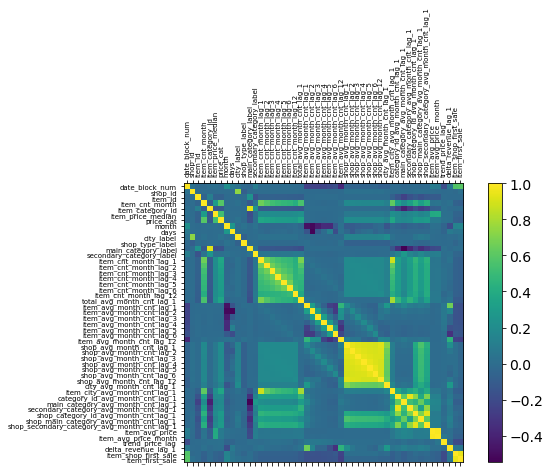

In [13]:
# Correlation matrix for monthly sales
all_pairs2 = all_pairs[all_pairs['date_block_num']<34]
#all_data2 = all_data2.drop(columns=['in_test', 'is_new_item'], inplace=True)

# Correlation matrix
f = plt.figure(figsize=(9, 5))
plt.matshow(all_pairs2.corr(), fignum=f.number)
plt.xticks(range(all_pairs2.shape[1]),all_pairs2.columns, fontsize=7, rotation=90)
plt.yticks(range(all_pairs2.shape[1]), all_pairs2.columns, fontsize=7)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [14]:
ts = time.time()
all_pairs = all_pairs[all_pairs.date_block_num > 11]
time.time() - ts

ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

all_pairs = fill_na(all_pairs)
all_pairs.fillna(0, inplace=True)    
time.time() - ts

1.7430517673492432

In [15]:
all_pairs.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month',
       'item_category_id', 'item_price_median', 'price_cat', 'month', 'days',
       'city_label', 'shop_type_label', 'main_category_label',
       'secondary_category_label', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_12',
       'total_avg_month_cnt_lag_1', 'item_avg_month_cnt_lag_1',
       'item_avg_month_cnt_lag_2', 'item_avg_month_cnt_lag_3',
       'item_avg_month_cnt_lag_4', 'item_avg_month_cnt_lag_5',
       'item_avg_month_cnt_lag_6', 'item_avg_month_cnt_lag_12',
       'shop_avg_month_cnt_lag_1', 'shop_avg_month_cnt_lag_2',
       'shop_avg_month_cnt_lag_3', 'shop_avg_month_cnt_lag_4',
       'shop_avg_month_cnt_lag_5', 'shop_avg_month_cnt_lag_6',
       'shop_avg_month_cnt_lag_12', 'city_avg_month_cnt_lag_1',
       'item_city_avg_month_cnt_lag_1', 'category_id_avg_month_cnt_la

In [16]:
all_pairs.drop(['item_price_median', 'price_cat', 'item_avg_price', 'item_avg_price_month',
               'main_category_avg_month_cnt_lag_1','secondary_category_avg_month_cnt_lag_1',
               'shop_main_category_avg_month_cnt_lag_1','shop_secondary_category_avg_month_cnt_lag_1'], inplace=True, axis=1)

In [17]:
all_pairs.to_pickle('data.pkl')
data = pd.read_pickle('data.pkl')

X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
gc.collect();

In [ ]:
# model=lgb.LGBMRegressor(
#         n_estimators=10000,
#         learning_rate=0.3,
#         min_child_weight=300,
#         #num_leaves=32,
#         colsample_bytree=0.8,
#         subsample=0.8,
#         max_depth=8,
#         #reg_alpha=0.04,
#         #reg_lambda=0.073,
#         #min_split_gain=0.0222415,
#         verbose=1,
#         seed=21)

# model.fit(X_train, Y_train,eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=1, early_stopping_rounds = 10)

# # Cross validation accuracy for 3 folds
# #scores = cross_val_score(model, X_train, Y_train, cv=3)
# #print(scores)

In [ ]:
#2nd approach using XGB
ts = time.time()

model = XGBRegressor(
        max_depth=8,
        n_estimators=1000,
        min_child_weight=300,
        colsample_bytree=0.8,
        subsample=0.8,
        eta=0.3,
        seed=21
    )

model.fit(X_train, Y_train,eval_metric="rmse", eval_set=[(X_train, Y_train), (X_valid, Y_valid)], verbose=1, early_stopping_rounds = 10)

time.time() - ts

C:\Users\jayes\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\jayes\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:46:32] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:32] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12366	validation_1-rmse:1.11657
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.08541	validation_1-rmse:1.08271
[2]	validation_0-rmse:1.05459	validation_1-rmse:1.05483
[3]	validation_0-rmse:1.01027	validation_1-rmse:1.02804
[4]	validation_0-rmse:0.98377	validation_1-rmse:1.00698
[5]	validation_0-rmse:0.963238	validation_1-rmse:0.991593
[6]	validation_0-rmse:0.945051	validation_1-rmse:0.975889
[7]	validation_0-rmse:0.923647	validation_1-rmse:0.963194
[8]	validation_0-rmse:0.909462	validation_1-rmse:0.953828
[9]	valida

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [ ]:
submission